# importations

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split
import matplotlib.pyplot as plt

# preparation données 

In [ ]:

class ECGDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        
        self.tabular_features = ["age", "sex", "height", "weight"]
        self.targets = [
            "P_Amp_V1", "P_Amp_II", "P_Amp_I", "P_Dur_Global", "PR_Int_Global",
            "QT_IntFramingham_Global", "S_Amp_Global", "PQ_Int_Global", 
            "QRS_Dur_Global", "RR_Mean_Global", "QT_Int_Global"
        ]

        # Normalisation des données tabulaires (standardisation)
        self.scaler = StandardScaler()
        self.data[self.tabular_features] = self.scaler.fit_transform(self.data[self.tabular_features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = row["filename_lr"].split("/")[-1] + ".png"
        img_path = os.path.join(self.img_dir, filename)

        if not os.path.exists(img_path):
            print(f"⚠️ Image non trouvée: {img_path}")
            return None
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        tabular_data = torch.tensor(row[self.tabular_features].values.astype(float), dtype=torch.float32)
        target = torch.tensor(row[self.targets].values.astype(float), dtype=torch.float32)

        return image, tabular_data, target


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])


In [ ]:

class ECGModel(nn.Module):
    def __init__(self):
        super(ECGModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 256)

        self.mlp = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 11)
        )

    def forward(self, image, tabular):
        x1 = self.resnet(image)
        x2 = self.mlp(tabular)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# entrainement modele 

In [ ]:

def train_model(csv_path, img_dir, num_epochs=50, batch_size=32, lr=0.001, weight_decay=5e-4, patience=7):
    dataset = ECGDataset(csv_path, img_dir, transform=transform)

    # Éliminer les données invalides
    dataset = [data for data in dataset if data is not None]
    if len(dataset) == 0:
        print("❌ Aucun fichier image valide trouvé. Vérifiez votre dossier !")
        return None, None, None

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ECGModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, targets in train_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, tabular_data, targets in val_loader:
                images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
                outputs = model(images, tabular_data)
                val_loss = criterion(outputs, targets)
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"🛑 Early stopping triggered at epoch {epoch+1}")
                break

    print("✅ Entraînement terminé !")

    return model, val_loader, test_loader,train_losses,val_losses

csv_path = "ecg_mesures.csv"
img_dir = "ECG_images_Filtered"
model, val_loader, test_loader,train_losses,val_losses= train_model(csv_path, img_dir)


⚠️ Image non trouvée: ECG_images_Filtered\00317_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\01986_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18631_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18634_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18635_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18636_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18638_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18639_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18640_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18641_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18643_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18644_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18649_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18651_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18652_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18653_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18654_lr.png
⚠️ Image non trouvée: ECG_images_Filtered\18673_lr.png
⚠️ Image n

c:\Users\pc\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\pc\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Loss: 15996.8121 | Val Loss: 1573.2862
Epoch [2/50] - Train Loss: 1778.5894 | Val Loss: 1665.9616
Epoch [3/50] - Train Loss: 1700.4318 | Val Loss: 1723.6118
Epoch [4/50] - Train Loss: 1363.3657 | Val Loss: 949.4727
Epoch [5/50] - Train Loss: 1071.0928 | Val Loss: 1040.9941
Epoch [6/50] - Train Loss: 950.5772 | Val Loss: 1625.8921
Epoch [7/50] - Train Loss: 1002.3941 | Val Loss: 828.0265
Epoch [8/50] - Train Loss: 866.4437 | Val Loss: 823.1441
Epoch [9/50] - Train Loss: 780.3167 | Val Loss: 5322.9725
Epoch [10/50] - Train Loss: 802.6800 | Val Loss: 678.7592
Epoch [11/50] - Train Loss: 771.2007 | Val Loss: 880.9830
Epoch [12/50] - Train Loss: 682.1252 | Val Loss: 687.5600
Epoch [13/50] - Train Loss: 672.3254 | Val Loss: 708.1868
Epoch [14/50] - Train Loss: 633.3585 | Val Loss: 680.7012
Epoch [15/50] - Train Loss: 579.0694 | Val Loss: 824.2650
Epoch [16/50] - Train Loss: 560.8573 | Val Loss: 642.1592
Epoch [17/50] - Train Loss: 546.6997 | Val Loss: 971.2879
Epoch [18/

# validation

In [40]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Épochs')
    plt.ylabel('Loss')
    plt.title('Courbes de Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


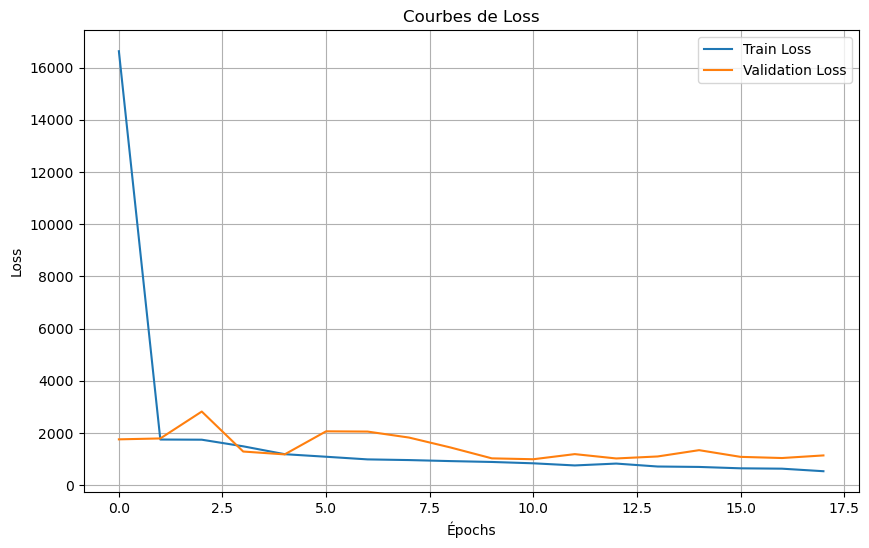

In [41]:
plot_loss_curves(train_losses, val_losses)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# === 5. Évaluation du modèle ===
def calcul_metric(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Mode évaluation
    
    criterion = nn.MSELoss()  # Fonction de perte MSE
    mae_loss = nn.L1Loss()  # Mean Absolute Error

    total_mse = 0.0
    total_mae = 0.0
    total_r2 = 0.0  # Initialisation du calcul du R²
    total_rmse = 0.0  # Initialisation RMSE
    total_mape = 0.0  # Initialisation MAPE
    total_smape = 0.0  # Initialisation SMAPE
    num_batches = 0

    epsilon = 1e-8  # Pour éviter la division par zéro

    with torch.no_grad():  # Pas de calcul de gradients
        for images, tabular_data, targets in test_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)

            outputs = model(images, tabular_data)

            # Calcul des métriques
            mse = criterion(outputs, targets).item()
            mae = mae_loss(outputs, targets).item()
            rmse = np.sqrt(mse)  # Racine carrée de MSE
            
            # MAPE (Mean Absolute Percentage Error)
            mape = torch.mean(torch.abs((targets - outputs) / (targets + epsilon))) * 100

            # SMAPE (Symmetric Mean Absolute Percentage Error)
            smape = torch.mean(2 * torch.abs(targets - outputs) / (torch.abs(targets) + torch.abs(outputs) + epsilon)) * 100

            # Calcul du R² (Coefficient de détermination)
            ss_tot = torch.sum((targets - torch.mean(targets, dim=0)) ** 2)  # Somme des carrés totaux
            ss_res = torch.sum((targets - outputs) ** 2)  # Somme des carrés résiduels
            r2 = 1 - (ss_res / ss_tot).item()

            # Ajouter aux sommes
            total_mse += mse
            total_mae += mae
            total_r2 += r2
            total_rmse += rmse
            total_mape += mape.item()
            total_smape += smape.item()

            num_batches += 1

    # Moyenne des erreurs et du R²
    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    avg_r2 = total_r2 / num_batches
    avg_rmse = total_rmse / num_batches
    avg_smape = total_smape / num_batches

    # Affichage des résultats
    print(f"\n📊 **Résultats de l'évaluation :**")
    print(f"🔹 MSE (Mean Squared Error) : {avg_mse:.4f}")
    print(f"🔹 RMSE (Root Mean Squared Error) : {avg_rmse:.4f}")
    print(f"🔹 MAE (Mean Absolute Error) : {avg_mae:.4f}")
    print(f"🔹 SMAPE (Symmetric Mean Absolute Percentage Error) : {avg_smape:.2f}%")
    print(f"🔹 R² (Coefficient de Détermination) : {avg_r2:.4f}")
    
    return avg_mse, avg_rmse, avg_mae, avg_smape, avg_r2

# Lancer l'évaluation après l'entraînement
if model:
    calcul_metric(model, test_loader)



📊 **Résultats de l'évaluation :**
🔹 MSE (Mean Squared Error) : 670.6603
🔹 RMSE (Root Mean Squared Error) : 23.8152
🔹 MAE (Mean Absolute Error) : 13.2080
🔹 SMAPE (Symmetric Mean Absolute Percentage Error) : 49.49%
🔹 R² (Coefficient de Détermination) : 0.8543


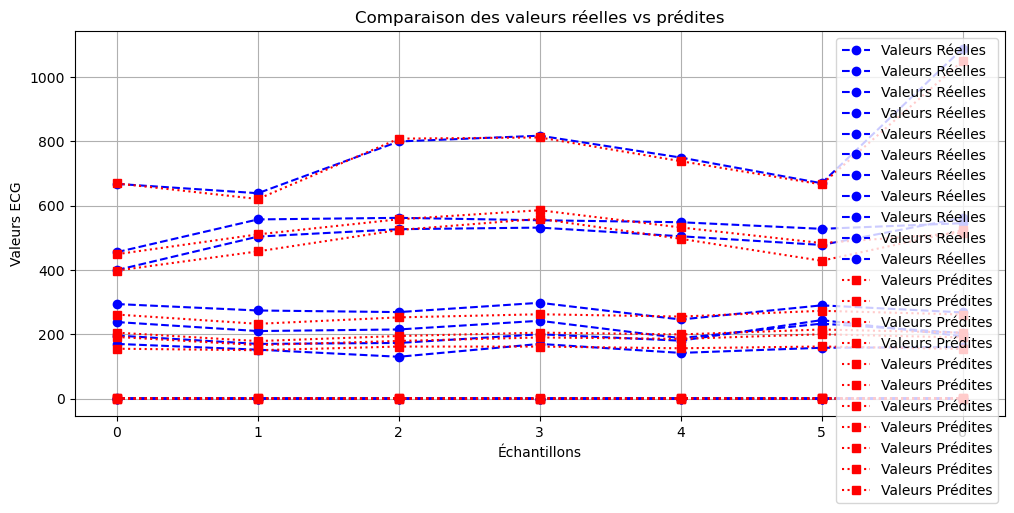


📊 Comparaison des valeurs pour un échantillon :
                      Label  Valeur Réelle  Valeur Prédite
0                  P_Amp_V1        -0.0050          0.0634
1                  P_Amp_II         0.0250          0.0998
2                   P_Amp_I         0.0150          0.0197
3              P_Dur_Global       221.0000        236.4330
4             PR_Int_Global       305.0000        314.3142
5   QT_IntFramingham_Global       729.2000        635.2321
6              S_Amp_Global        -0.0717         -0.2399
7             PQ_Int_Global       252.0000        254.2828
8            QRS_Dur_Global       128.0000        169.2028
9            RR_Mean_Global      1234.0000       1237.4689
10            QT_Int_Global       759.0000        670.6179

📊 Comparaison des valeurs pour un échantillon :
                      Label  Valeur Réelle  Valeur Prédite
0                  P_Amp_V1        -0.0400          0.0092
1                  P_Amp_II         0.0300          0.0768
2                

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === 5. Évaluation du modèle ===
def evaluate_model(model, test_loader):
    # Définir le device (CPU ou GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Assurer que le modèle est sur le bon device
    
    model.eval()  # Passer le modèle en mode évaluation
    y_test = []
    y_pred = []
    
    # Désactiver le calcul des gradients pour l'évaluation
    with torch.no_grad():
        for images, tabular_data, targets in test_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)

            # Passer les données à travers le modèle
            outputs = model(images, tabular_data)
            
            # Ajouter les prédictions et les vraies valeurs aux listes
            y_pred.append(outputs.cpu().numpy())
            y_test.append(targets.cpu().numpy())

    # Convertir les listes en tableaux numpy
    y_test = np.concatenate(y_test, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    return y_test, y_pred

# Lancer l'évaluation après l'entraînement
if model:
    y_test, y_pred = evaluate_model(model, test_loader)  # Obtenir les résultats

    # Liste des labels ECG pour l'affichage
    ecg_labels = ['P_Amp_V1', 'P_Amp_II', 'P_Amp_I', 'P_Dur_Global', 'PR_Int_Global',
                  'QT_IntFramingham_Global', 'S_Amp_Global', 'PQ_Int_Global', 
                  'QRS_Dur_Global', 'RR_Mean_Global', 'QT_Int_Global']

    # Sélection des 10 premiers échantillons pour affichage
    num_samples = 7
    y_test_sample = y_test[:num_samples]
    y_pred_sample = y_pred[:num_samples]

    # 📊 AFFICHAGE DU GRAPHE
    plt.figure(figsize=(12, 5))

    # Tracer les valeurs réelles et prédites
    plt.plot(y_test_sample, marker='o', linestyle='dashed', color='blue', label="Valeurs Réelles")
    plt.plot(y_pred_sample, marker='s', linestyle='dotted', color='red', label="Valeurs Prédites")

    plt.xlabel("Échantillons")
    plt.ylabel("Valeurs ECG")
    plt.title("Comparaison des valeurs réelles vs prédites")
    plt.legend()
    plt.grid(True)
    plt.show()
    for i in range(30,40):
        # 📌 AFFICHAGE D'UN EXEMPLE DE VECTEUR NUMÉRIQUE ET SA PRÉDICTION
        index_example =i # Choisir le premier échantillon
        example_real = y_test[index_example]
        example_pred = y_pred[index_example]

        df_comparaison = pd.DataFrame({
            "Label": ecg_labels,
            "Valeur Réelle": example_real,
            "Valeur Prédite": example_pred
        })

        # Supprimer les notations scientifiques (éviter les e-2, etc.)
        pd.set_option("display.float_format", "{:.4f}".format)

        print("\n📊 Comparaison des valeurs pour un échantillon :")
        print(df_comparaison)
